# Horizontally integrate multiple scRNA-seq samples
**Author**: Adam Klie (last modified: 10/12/2023)<br>
***
**Description**: This script 

# Set-up

In [1]:
# Imports
import os
import seaborn as sns
import anndata as ad
import glob
import scanpy as sc

import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# R interface
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.rinterface_lib.callbacks

# Activate R interface
pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

by .GlobalEnv when processing object ‘.pbd_env’
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects

In [2]:
# List h5ads to integrate
results_paths = ["/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander"]

In [3]:
# List h5ads to integrate
h5ad_paths = []
for results_path in results_paths:
    h5ad_paths += sorted(glob.glob(os.path.join(results_path, "*", "annotate", "publication", "*.h5ad")))
len(h5ad_paths), h5ad_paths

(5,
 ['/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D11/annotate/publication/annotated.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D14/annotate/publication/annotated.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D21/annotate/publication/annotated.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D32/annotate/publication/annotated.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D39/annotate/publication/annotated.h5ad'])

# Load and concatenate data

In [4]:
# Read in samples
adata_list = []
samples = []
for h5ad_path in h5ad_paths:
    sample = h5ad_path.split("/")[-4]
    print(f"Loading {sample}")
    adata = sc.read_h5ad(h5ad_path)
    adata.obs.index = sample + "_" + adata.obs.index
    adata_cp = sc.AnnData(adata.layers["counts"].copy(), obs=adata.obs.copy(), var=adata.var.copy())
    adata_list.append(adata_cp)
    samples.append(sample)
samples

Loading H1-D11


Loading H1-D14
Loading H1-D21
Loading H1-D32
Loading H1-D39


['H1-D11', 'H1-D14', 'H1-D21', 'H1-D32', 'H1-D39']

In [5]:
# Concat samples
adata_concat = ad.concat(adata_list, label="sample", keys=samples)
adata_concat.obs["sample"].value_counts()

H1-D11    8168
H1-D14    6999
H1-D21    2186
H1-D32    1820
H1-D39    1714
Name: sample, dtype: int64

In [6]:
# What do cell identities look like
adata_concat.obs["cellid"].value_counts()

PP1          4382
ENP1         3853
SC.alpha     2525
ENP2         2499
ENP.alpha    2197
ENP3         2050
SC.EC        1163
PP2          1037
SC.beta      1010
SC.delta      171
Name: cellid, dtype: int64

In [7]:
# Get the cluster proportions across samples
cross_tab = pd.crosstab(adata_concat.obs["sample"], adata_concat.obs["cellid"])
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab_norm

cellid      ENP1      ENP2      ENP3  ENP.alpha       PP1       PP2     SC.EC  \
sample                                                                          
H1-D11  0.469760  0.000000  0.000000   0.000000  0.530240  0.000000  0.000000   
H1-D14  0.002286  0.351479  0.200029   0.306329  0.000000  0.106587  0.000000   
H1-D21  0.000000  0.017841  0.207685   0.024245  0.000000  0.108875  0.172919   
H1-D32  0.000000  0.000000  0.066484   0.000000  0.013187  0.018681  0.255495   
H1-D39  0.000000  0.000000  0.043757   0.000000  0.015753  0.011085  0.186698   

cellid  SC.alpha   SC.beta  SC.delta  
sample                                
H1-D11  0.000000  0.000000  0.000000  
H1-D14  0.001572  0.031719  0.000000  
H1-D21  0.280421  0.171546  0.016468  
H1-D32  0.486264  0.133516  0.026374  
H1-D39  0.592765  0.099183  0.050758

<Axes: xlabel='sample'>

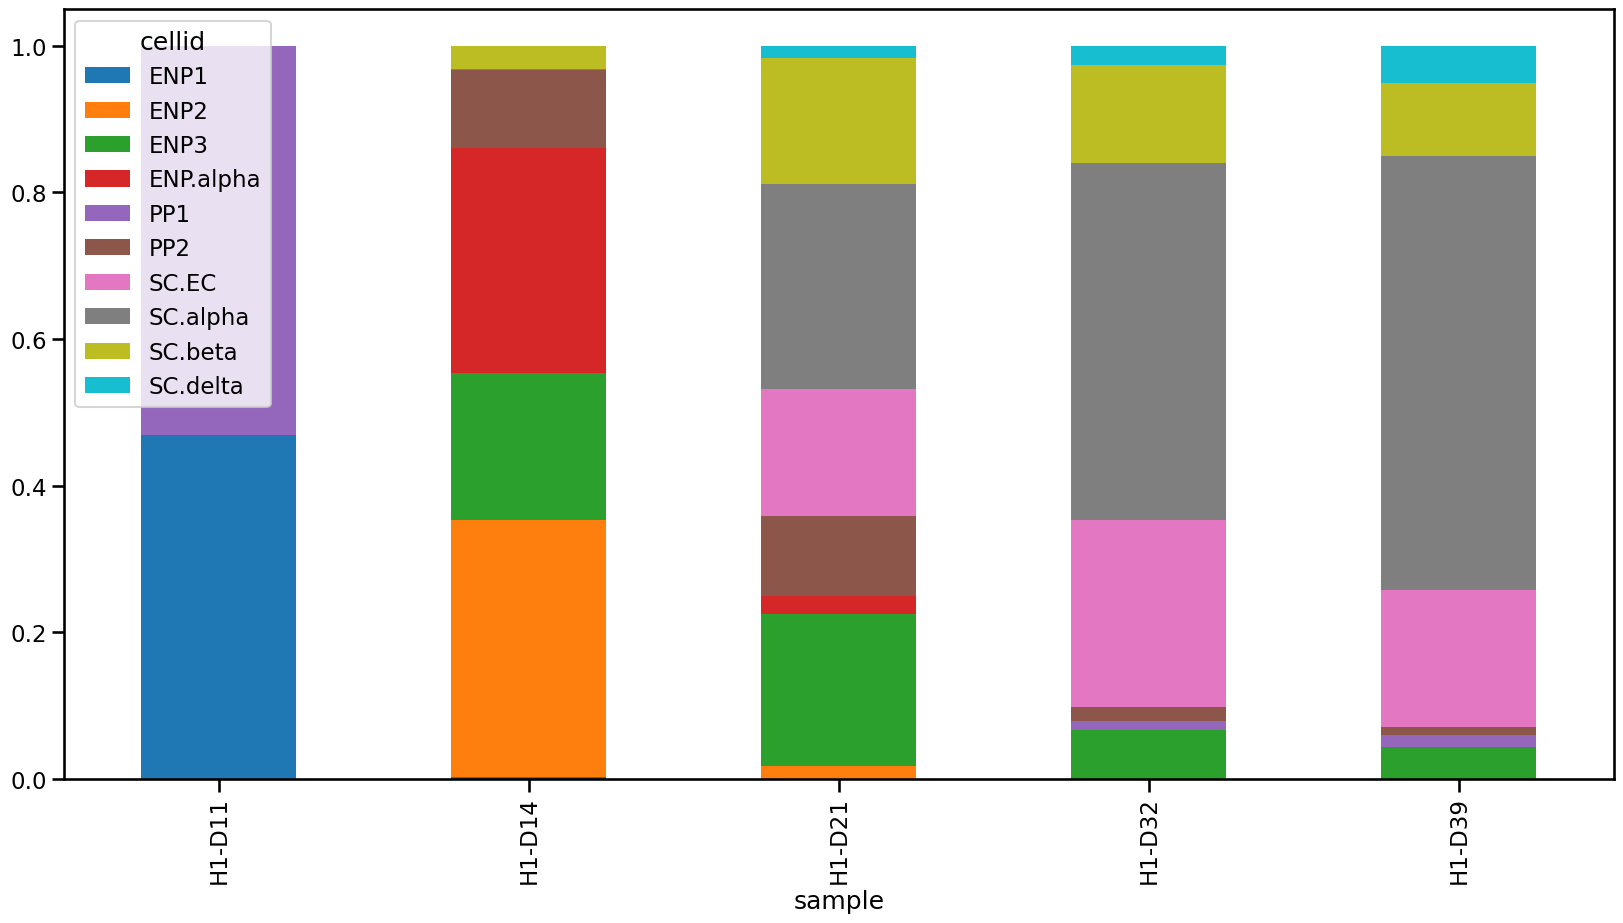

In [8]:
# Make a pretty bar plot with x-axis showing sample and y-axis showing manual_cellid_annotation
cross_tab_norm.plot.bar(stacked=True, figsize=(20, 10))

# Batch correction

In [9]:
# Set paramaters
batch_key = "sample"
n_comps = 50
n_neighbors = 30
umap_min_dist = 0.3
leiden_resolution = 1
random_state = 1234

In [10]:
# Save counts in adata_concat.raw
adata_concat.raw = adata_concat.copy()

In [11]:
# Save counts in adata_concat.layers["counts"]
adata_concat.layers["counts"] = adata_concat.X.copy()
adata_concat

AnnData object with n_obs × n_vars = 20887 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid', 'sample'
    layers: 'counts'

# Unintegrated log1p normalized data

In [12]:
# Create a copy for unintegrated log1p
adata_log1p = adata_concat.copy()
adata_log1p

AnnData object with n_obs × n_vars = 20887 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid', 'sample'
    layers: 'counts'

In [13]:
# Normalize data based on all cells
sc.pp.normalize_total(adata_log1p)
sc.pp.log1p(adata_log1p)
adata_log1p.layers["logcounts"] = adata_log1p.X.copy()

In [14]:
# Select highly variable genes for PCA
sc.pp.highly_variable_genes(adata_log1p)

In [15]:
# Run PCA
sc.tl.pca(adata_log1p, n_comps=n_comps, svd_solver="arpack", use_highly_variable=True, zero_center=True, dtype="float32", copy=False, random_state=random_state)

In [16]:
# Find neighbors
sc.pp.neighbors(adata_log1p, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Run UMAP
sc.tl.umap(adata_log1p, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="unintegrated")

In [18]:
# Cluster unintegrated data
sc.tl.leiden(adata_log1p, key_added=f"log1p_unintegrated_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state) #, neighbors_key="unintegrated")

In [19]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_log1p,
    label_key="cellid",
    cluster_key="log1p_unintegrated_leiden_optimal",
    use_rep="X_pca",
)

Compute neighbors on rep X_pca


resolution: 0.1, nmi: 0.7980936484902166
resolution: 0.2, nmi: 0.8074946809633914
resolution: 0.3, nmi: 0.8005359602756843
resolution: 0.4, nmi: 0.8290238965315515
resolution: 0.5, nmi: 0.8099505804212301
resolution: 0.6, nmi: 0.7938119772419112
resolution: 0.7, nmi: 0.7962815848222172
resolution: 0.8, nmi: 0.7963597465994645
resolution: 0.9, nmi: 0.7798240022095068
resolution: 1.0, nmi: 0.76292282963892
resolution: 1.1, nmi: 0.7667774263218652
resolution: 1.2, nmi: 0.7578511370359552
resolution: 1.3, nmi: 0.763984561628672
resolution: 1.4, nmi: 0.747381880001843
resolution: 1.5, nmi: 0.7368730873086213
resolution: 1.6, nmi: 0.7215085510574006
resolution: 1.7, nmi: 0.7143229250689316
resolution: 1.8, nmi: 0.7072694446673734
resolution: 1.9, nmi: 0.7055417661297967
resolution: 2.0, nmi: 0.709234776991001
optimised clustering against cellid
optimal cluster resolution: 0.4
optimal score: 0.8290238965315515


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


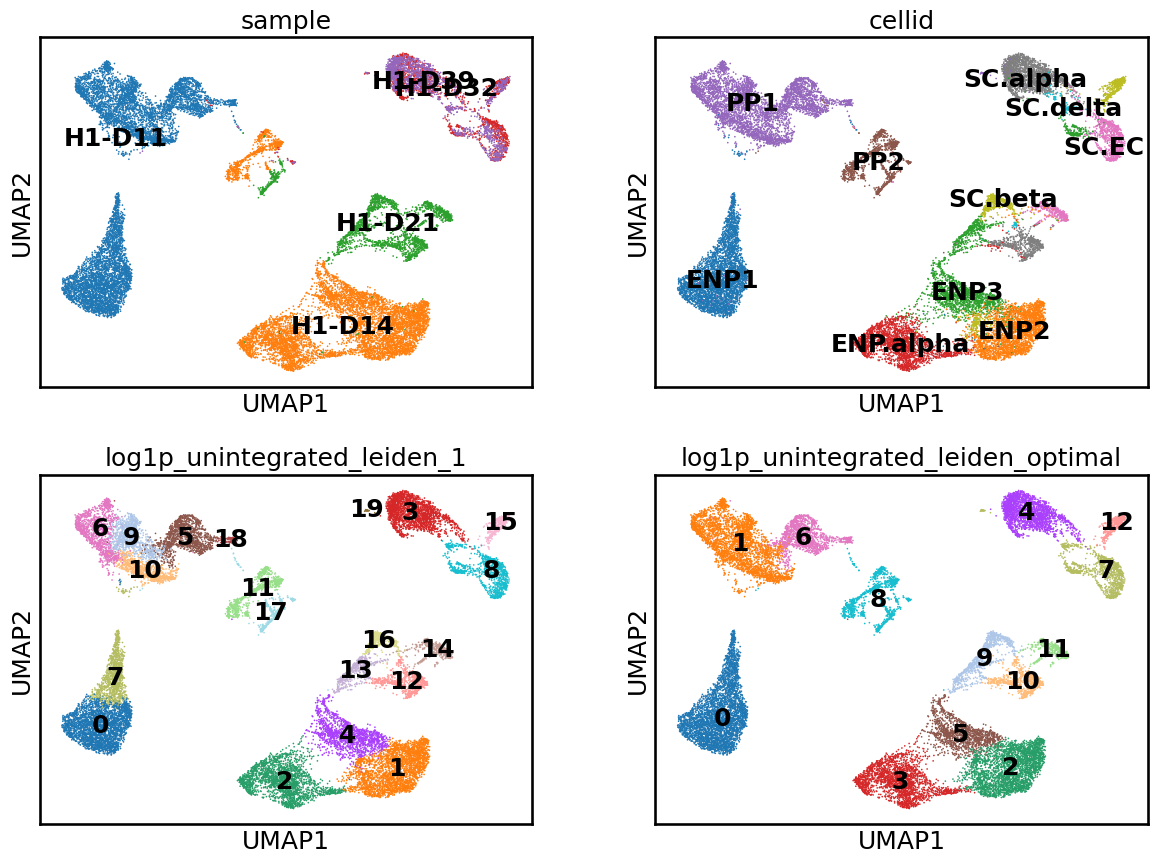

In [20]:
# Plot with sample colors
sc.pl.umap(
    adata_log1p, 
    color=[
        "sample", 
        "cellid", 
        f"log1p_unintegrated_leiden_{leiden_resolution}", 
        "log1p_unintegrated_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


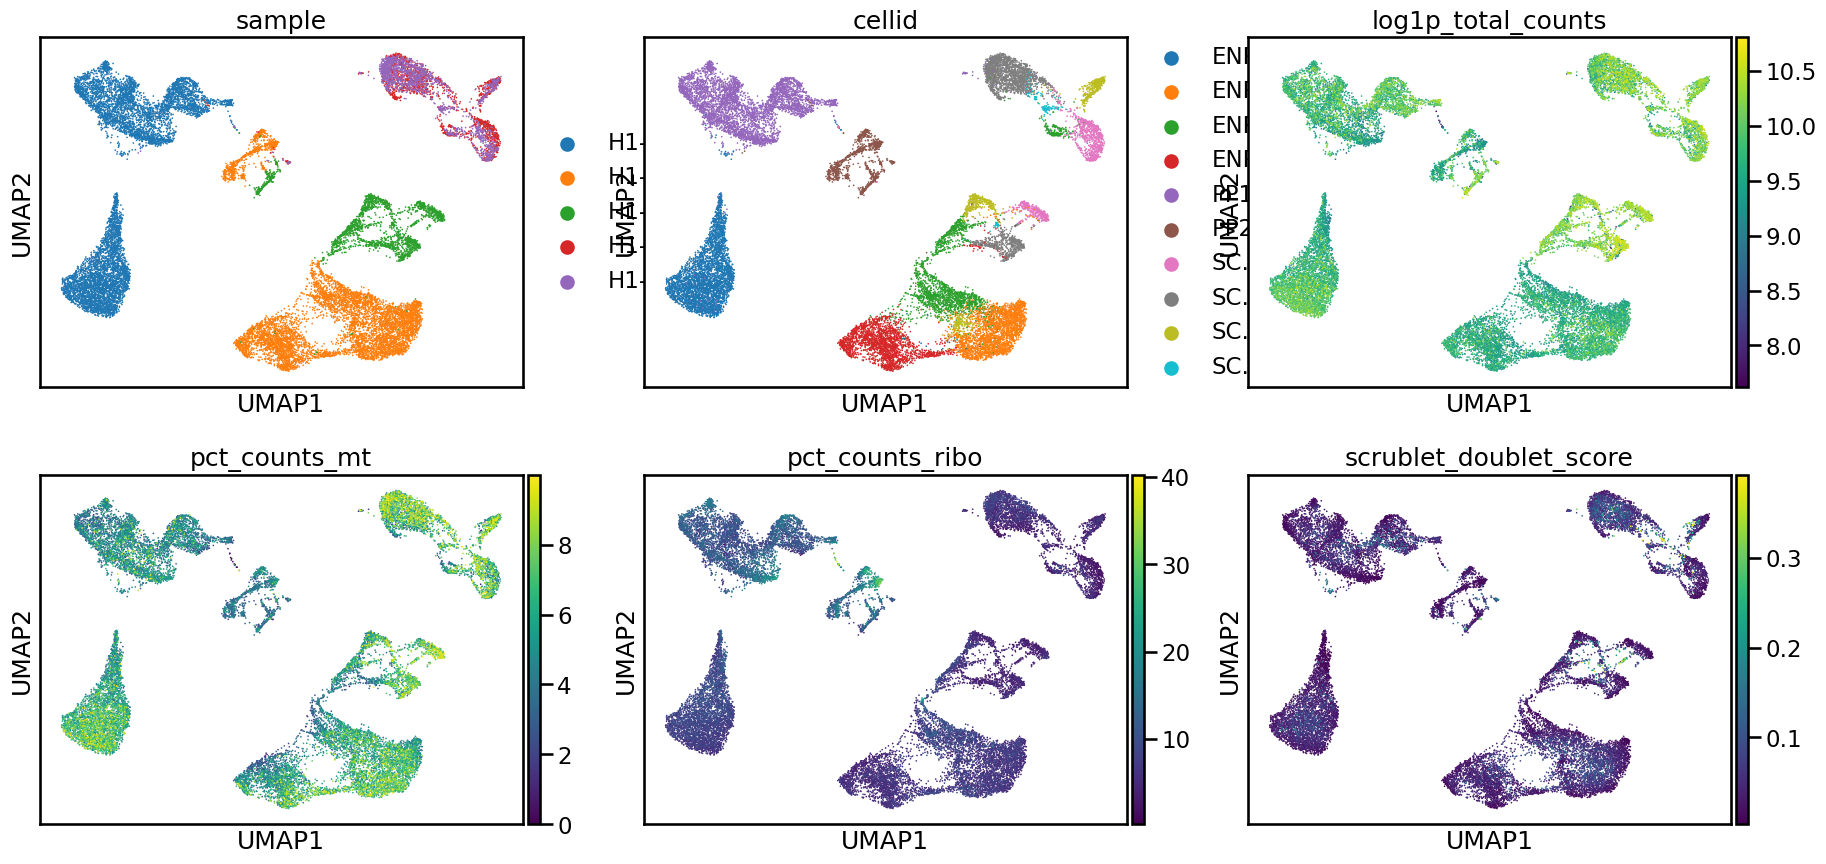

In [21]:
# Plot technical covariates
sc.pl.umap(
    adata_log1p, 
    color=[
        "sample", 
        "cellid", 
        "log1p_total_counts",
        "pct_counts_mt",
        "pct_counts_ribo",
        "scrublet_doublet_score"
    ], 
    ncols=3, 
)

# Unintegrated SCTransformed normalized data

In [22]:
%%R
library(Seurat)
library(SeuratObject)
library(Matrix)
library(harmony)

R[write to console]: The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Loading required package: Rcpp



In [23]:
# Make a copy of the original data
adata_sctransform = adata_concat.copy()
adata_sctransform

AnnData object with n_obs × n_vars = 20887 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid', 'sample'
    layers: 'counts'

In [24]:
# Prepare data for Seurat
data_mat = adata_sctransform.layers["counts"].T.astype("float32")
cell_names = adata_sctransform.obs_names
gene_names = adata_sctransform.var_names
metadata = adata_sctransform.obs

In [25]:
# Load into global environment
ro.globalenv["data_mat"] = data_mat
ro.globalenv["cell_names"] = cell_names
ro.globalenv["gene_names"] = gene_names
ro.globalenv["metadata"] = metadata

In [26]:
%%R
mtx = Matrix(data_mat, sparse = TRUE)
rownames(mtx) = gene_names
colnames(mtx) = cell_names
sobj = CreateSeuratObject(counts = mtx, assay = "RNA")
sobj$sample = metadata$sample
sobj = SCTransform(sobj, verbose = FALSE, method = "glmGamPoi")

In [27]:
%%R -o scale_data -o variable_genes
scale_data = GetAssayData(object = sobj, assay = "SCT", slot = "scale.data")
variable_genes = VariableFeatures(object = sobj)

In [28]:
# Create the dataframe
scale_data_df = pd.DataFrame(data=scale_data.T, index=cell_names, columns=variable_genes)

In [29]:
# Add to adata
adata_sctransform.obsm["sctransform_scale_data"] = scale_data_df
adata_sctransform.var["sctransform_genes"] = adata_sctransform.var.index.isin(variable_genes)

In [30]:
# Run PCA on the obsm
adata_sctransform.obsm["X_pca"] = sc.tl.pca(
    adata_sctransform.obsm["sctransform_scale_data"].values, 
    use_highly_variable=False, 
    n_comps=n_comps, 
    svd_solver="arpack", 
    random_state=random_state, 
    zero_center=True, 
    dtype="float32", 
    copy=False
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [31]:
# Find neighbors on this
sc.pp.neighbors(adata_sctransform, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

In [32]:
# Run UMAP
sc.tl.umap(adata_sctransform, min_dist=umap_min_dist, random_state=random_state)#, neighbors_key="unintegrated")

In [33]:
# Cluster unintegrated data
sc.tl.leiden(adata_sctransform, key_added=f"sctransform_unintegrated_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state)#, neighbors_key="unintegrated")

In [34]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_sctransform,
    label_key="cellid",
    cluster_key="sctransform_unintegrated_leiden_optimal",
    use_rep="X_pca",
)

Compute neighbors on rep X_pca
resolution: 0.1, nmi: 0.7940823618859378
resolution: 0.2, nmi: 0.8174201681644478
resolution: 0.3, nmi: 0.8071319491248146
resolution: 0.4, nmi: 0.7822338118423645
resolution: 0.5, nmi: 0.7722067333025624
resolution: 0.6, nmi: 0.778135788223438
resolution: 0.7, nmi: 0.7873850783888053
resolution: 0.8, nmi: 0.7912635239839866
resolution: 0.9, nmi: 0.7763524587656521
resolution: 1.0, nmi: 0.7686798917222774
resolution: 1.1, nmi: 0.7651714761922537
resolution: 1.2, nmi: 0.7415898970461753
resolution: 1.3, nmi: 0.723369589177462
resolution: 1.4, nmi: 0.7319862608079546
resolution: 1.5, nmi: 0.7282276101252181
resolution: 1.6, nmi: 0.7108447328207642
resolution: 1.7, nmi: 0.7033979176109793
resolution: 1.8, nmi: 0.7016113887389038
resolution: 1.9, nmi: 0.6922233247886259
resolution: 2.0, nmi: 0.6934647807236999
optimised clustering against cellid
optimal cluster resolution: 0.2
optimal score: 0.8174201681644478


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


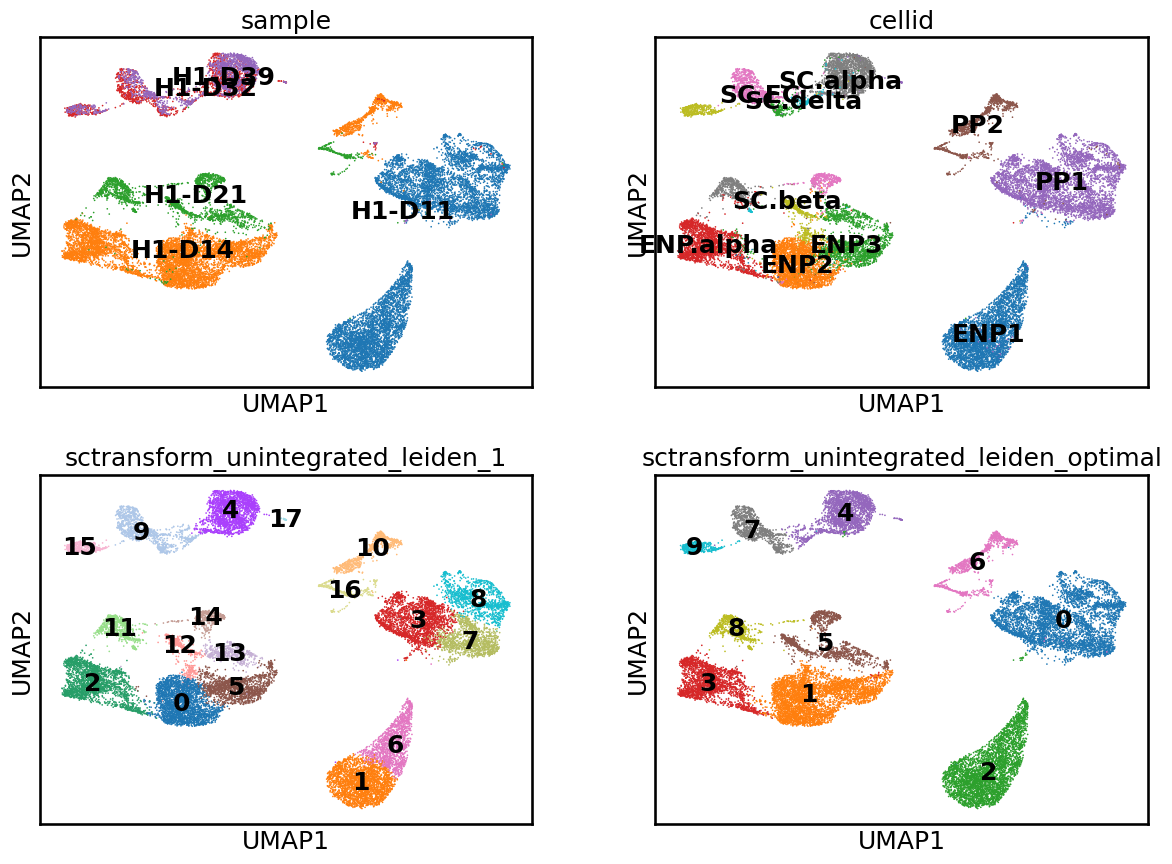

In [35]:
# Plot with sample colors
sc.pl.umap(
    adata_sctransform, 
    color=[
        "sample", 
        "cellid", 
        f"sctransform_unintegrated_leiden_{leiden_resolution}", 
        "sctransform_unintegrated_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Run Harmony integration in Python

In [36]:
import scanpy.external as sce

In [37]:
# Make another copy, this time of the unintegrated sctransform data
adata_harmony_py = adata_sctransform.copy()
adata_harmony_py

AnnData object with n_obs × n_vars = 20887 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid', 'sample', 'sctransform_unintegrated_leiden_1', 'sctransform_unintegrated_leiden_optimal'
    var: 'sctransform_genes'
    uns: 'neighbors', 'umap', 'leiden', 'sample_colors', 'cellid_colors', 'sctransform_unintegrated_leiden_1_colors', 'sctransform_unintegrated_leiden_optimal_colors'
    obsm: 'sctransform_scale_data', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [38]:
# Run the Python version of Harmony on the PCA from this
sce.pp.harmony_integrate(
    adata=adata_harmony_py,
    basis="X_pca",
    adjusted_basis="X_pca_harmony",
    key="sample",
)

2023-10-28 12:26:22,151 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-28 12:26:36,877 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-28 12:26:37,163 - harmonypy - INFO - Iteration 1 of 10
2023-10-28 12:26:48,553 - harmonypy - INFO - Iteration 2 of 10
2023-10-28 12:26:59,610 - harmonypy - INFO - Iteration 3 of 10
2023-10-28 12:27:10,530 - harmonypy - INFO - Iteration 4 of 10
2023-10-28 12:27:21,593 - harmonypy - INFO - Iteration 5 of 10
2023-10-28 12:27:32,705 - harmonypy - INFO - Iteration 6 of 10
2023-10-28 12:27:44,149 - harmonypy - INFO - Iteration 7 of 10
2023-10-28 12:27:55,618 - harmonypy - INFO - Iteration 8 of 10
2023-10-28 12:28:06,834 - harmonypy - INFO - Iteration 9 of 10
2023-10-28 12:28:18,253 - harmonypy - INFO - Converged after 9 iterations


In [39]:
# Find neighbors
sc.pp.neighbors(
    adata_harmony_py, 
    use_rep="X_pca_harmony", 
    n_neighbors=n_neighbors, 
    n_pcs=n_comps, 
    #key_added="harmony"
    random_state=random_state, 
)

In [40]:
# Run UMAP
sc.tl.umap(adata_harmony_py, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="harmony")

In [41]:
# Cluster unintegrated data
sc.tl.leiden(
    adata_harmony_py, 
    key_added=f"sctransform_harmony_leiden_{leiden_resolution}", 
    resolution=leiden_resolution, 
    random_state=random_state, 
    #neighbors_key="harmony"
)

In [42]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_harmony_py,
    label_key="cellid",
    cluster_key="sctransform_harmony_leiden_optimal",
    use_rep="X_pca_harmony",
)

Compute neighbors on rep X_pca_harmony


resolution: 0.1, nmi: 0.6121138267487116
resolution: 0.2, nmi: 0.6175598413667721
resolution: 0.3, nmi: 0.5965168062021888
resolution: 0.4, nmi: 0.588055539246085
resolution: 0.5, nmi: 0.5871521871397828
resolution: 0.6, nmi: 0.5856626790237526
resolution: 0.7, nmi: 0.5639107122780376
resolution: 0.8, nmi: 0.5941954269715743
resolution: 0.9, nmi: 0.5956883356791276
resolution: 1.0, nmi: 0.5898979409199862
resolution: 1.1, nmi: 0.5628416292723658
resolution: 1.2, nmi: 0.5874834726732285
resolution: 1.3, nmi: 0.5699527774335208
resolution: 1.4, nmi: 0.568411131020611
resolution: 1.5, nmi: 0.5624874768858917
resolution: 1.6, nmi: 0.5617516676280342
resolution: 1.7, nmi: 0.5609629992425228
resolution: 1.8, nmi: 0.568890156276955
resolution: 1.9, nmi: 0.5521316115705958
resolution: 2.0, nmi: 0.5542571345196248
optimised clustering against cellid
optimal cluster resolution: 0.2
optimal score: 0.6175598413667721


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


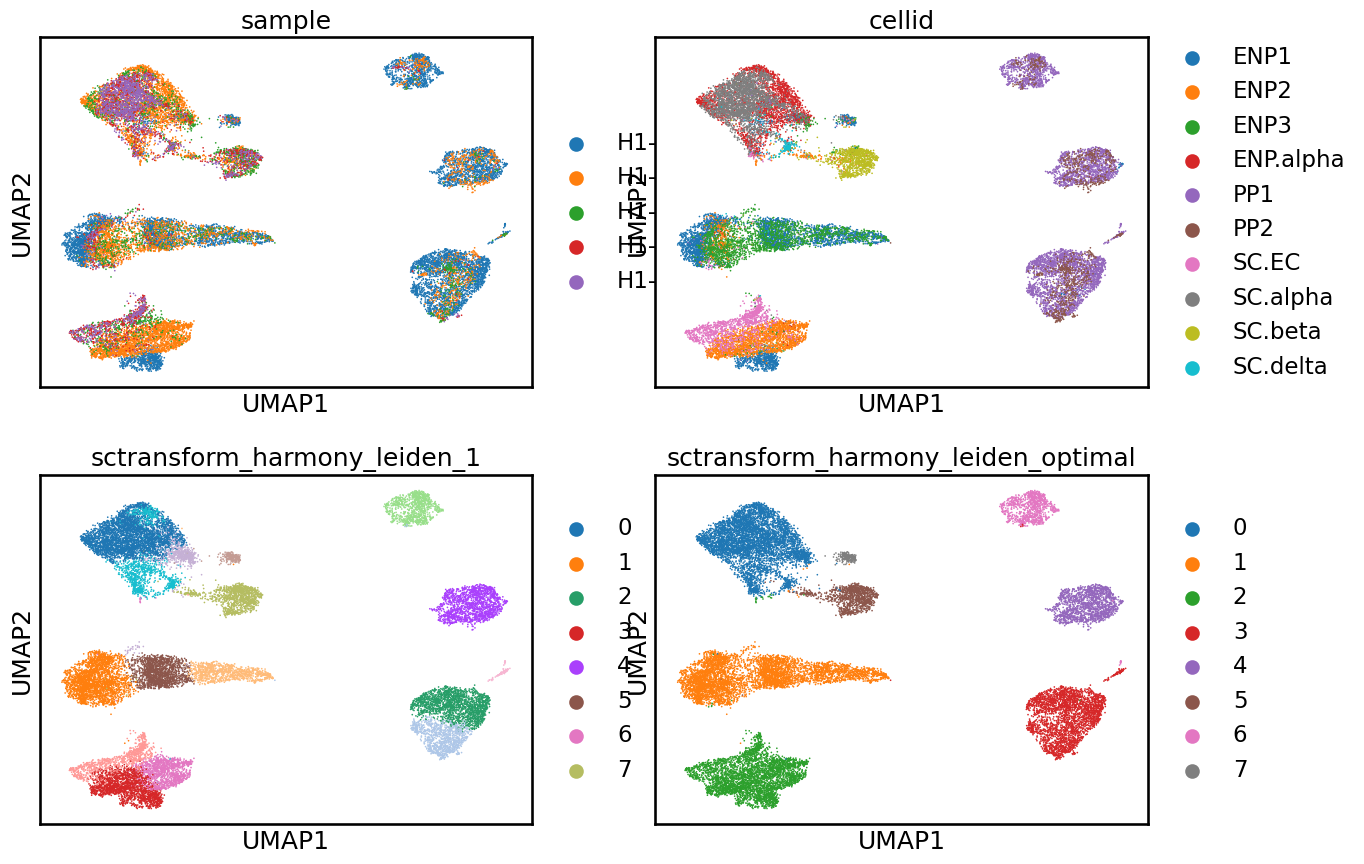

In [44]:
# Plot with sample colors
sc.pl.umap(
    adata_harmony_py, 
    color=[
        "sample", 
        "cellid", 
        f"sctransform_harmony_leiden_{leiden_resolution}", 
        "sctransform_harmony_leiden_optimal"
    ], 
    ncols=2,
)

# Run Harmony integration in R
Note: you must have run the R code in the SCTransform section to do this

In [45]:
# Make a copy of the original data
adata_harmony_R = adata_sctransform.copy()
adata_harmony_R

AnnData object with n_obs × n_vars = 20887 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid', 'sample', 'sctransform_unintegrated_leiden_1', 'sctransform_unintegrated_leiden_optimal'
    var: 'sctransform_genes'
    uns: 'neighbors', 'umap', 'leiden', 'sample_colors', 'cellid_colors', 'sctransform_unintegrated_leiden_1_colors', 'sctransform_unintegrated_leiden_optimal_colors'
    obsm: 'sctransform_scale_data', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [46]:
%%R -o harmony_embedding 
sobj <- RunPCA(sobj, verbose = FALSE)
sobj <- RunHarmony(
    object = sobj,
    group.by.vars = c('sample'),
    assay.use = 'SCT',
    max.iter.harmony=25,
    project.dim = FALSE
)
harmony_embedding = Embeddings(sobj, reduction = "harmony")

R[write to console]: Transposing data matrix

R[write to console]: Initializing state using k-means centroids initialization

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

In [47]:
# Grab the embedding to use
adata_harmony_R.obsm["X_pca_harmony"] = harmony_embedding

In [48]:
# Find neighbors
sc.pp.neighbors(
    adata_harmony_R, 
    use_rep="X_pca_harmony", 
    n_neighbors=n_neighbors, 
    n_pcs=n_comps, 
    #key_added="harmony"
    random_state=random_state, 
)

In [49]:
# Run UMAP
sc.tl.umap(adata_harmony_R, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="harmony")

In [50]:
# Cluster unintegrated data
sc.tl.leiden(
    adata_harmony_R, 
    key_added=f"sctransform_harmonyR_leiden_{leiden_resolution}", 
    resolution=leiden_resolution, 
    random_state=random_state, 
    #neighbors_key="harmony"
)

In [51]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_harmony_R,
    label_key="cellid",
    cluster_key="sctransform_harmonyR_leiden_optimal",
    use_rep="X_pca_harmony",
)

Compute neighbors on rep X_pca_harmony
resolution: 0.1, nmi: 0.6387208838739943
resolution: 0.2, nmi: 0.636707372277722
resolution: 0.3, nmi: 0.6076177999430847
resolution: 0.4, nmi: 0.6026093511996117
resolution: 0.5, nmi: 0.6043379590417575
resolution: 0.6, nmi: 0.5944614815851413
resolution: 0.7, nmi: 0.5954624066690831
resolution: 0.8, nmi: 0.5986860932674661
resolution: 0.9, nmi: 0.6187409154500544
resolution: 1.0, nmi: 0.6070610609152437
resolution: 1.1, nmi: 0.5818101573300771
resolution: 1.2, nmi: 0.5858725793725497
resolution: 1.3, nmi: 0.6111626914841898
resolution: 1.4, nmi: 0.5921052165729248
resolution: 1.5, nmi: 0.5939843971725883
resolution: 1.6, nmi: 0.5957742982538701
resolution: 1.7, nmi: 0.5936347097287089
resolution: 1.8, nmi: 0.5867341512591339
resolution: 1.9, nmi: 0.5902895489831635
resolution: 2.0, nmi: 0.5719431868759397
optimised clustering against cellid
optimal cluster resolution: 0.1
optimal score: 0.6387208838739943


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


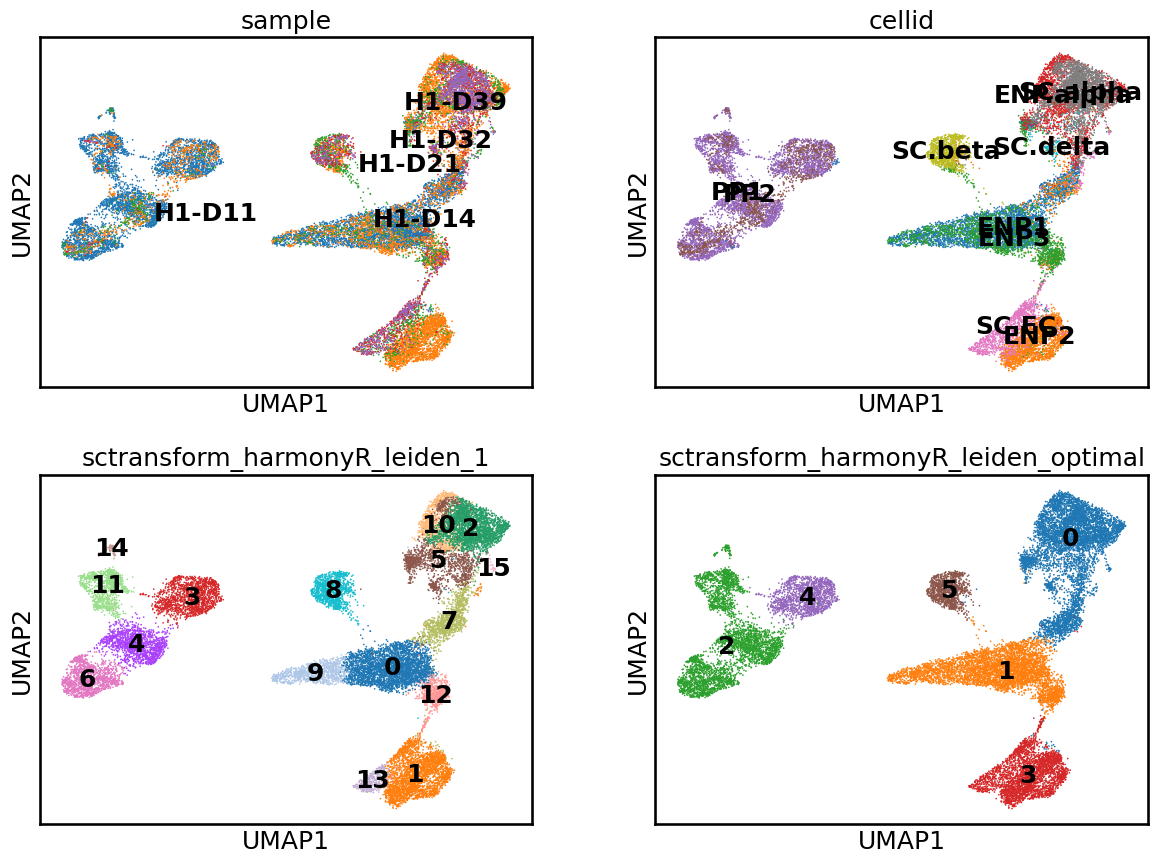

In [52]:
# Plot with sample colors
sc.pl.umap(
    adata_harmony_R, 
    color=[
        "sample", 
        "cellid", 
        f"sctransform_harmonyR_leiden_{leiden_resolution}", 
        "sctransform_harmonyR_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Seurat integration

In [53]:
# Make another copy
adata_seurat = adata_sctransform.copy()
adata_seurat

AnnData object with n_obs × n_vars = 20887 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid', 'sample', 'sctransform_unintegrated_leiden_1', 'sctransform_unintegrated_leiden_optimal'
    var: 'sctransform_genes'
    uns: 'neighbors', 'umap', 'leiden', 'sample_colors', 'cellid_colors', 'sctransform_unintegrated_leiden_1_colors', 'sctransform_unintegrated_leiden_optimal_colors'
    obsm: 'sctransform_scale_data', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [54]:
%%R
DefaultAssay(sobj) <- "RNA"
sobj.list <- SplitObject(sobj, split.by = "sample")
sobj.list <- lapply(X = sobj.list, FUN = function(x) {
    x <- NormalizeData(x, verbose = FALSE)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
})

In [55]:
%%R
features <- SelectIntegrationFeatures(object.list = sobj.list)
sobj.anchors <- FindIntegrationAnchors(object.list = sobj.list, anchor.features = features, verbose = FALSE)
sobj.combined <- IntegrateData(anchorset = sobj.anchors, verbose = FALSE)

  |                                                  | 0 % ~calculating   |+++++                                             | 10% ~23m 12s       |++++++++++                                        | 20% ~13m 17s       |+++++++++++++++                                   | 30% ~09m 21s       |++++++++++++++++++++                              | 40% ~07m 04s       |+++++++++++++++++++++++++                         | 50% ~05m 18s       |++++++++++++++++++++++++++++++                    | 60% ~03m 40s       |+++++++++++++++++++++++++++++++++++               | 70% ~02m 39s       |++++++++++++++++++++++++++++++++++++++++          | 80% ~01m 41s       |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~46s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=07m 09s


In [56]:
%%R -o integrated_expr
integrated_expr <- GetAssayData(sobj.combined)
integrated_expr <- integrated_expr[, colnames(sobj)]
integrated_expr <- t(integrated_expr)
print(integrated_expr[1:10, 1:10])

10 x 10 sparse Matrix of class "dgCMatrix"


R[write to console]:   [[ suppressing 10 column names ‘SST’, ‘AFP’, ‘LYZ’ ... ]]



                                                                               
H1-D11_TCTATCACACAGCCAC-1 -0.066953021 -1.361711e-02  0.038035304 -0.0300069279
H1-D11_AAAGGGCAGCTTTCTT-1 -0.081184942  5.215494e-01  0.038972791  0.8273631168
H1-D11_TGGGAGAGTATCGAGG-1 -0.033570368 -5.609531e-02  0.276231684  0.1280919269
H1-D11_GATCAGTGTCTTCATT-1  0.039587159 -2.505572e-02  0.110302223  0.0951084633
H1-D11_CACGGGTCATTCTCTA-1 -0.005140885  2.402256e-01  0.055997360  0.1281544357
H1-D11_CTCCCTCTCGCCAATA-1 -0.005256497  6.882210e-01  0.546028045 -0.0061502078
H1-D11_CTCCACAAGGGAGTTC-1 -0.079850402 -3.442487e-01 -0.019158471  0.3131074570
H1-D11_TCACTCGCAATCTAGC-1 -0.077658697  6.272612e-01  0.206989237 -0.1706706088
H1-D11_CATTTCATCCGTCACT-1  0.109145258  1.896793e-05  0.425231938 -0.0009282645
H1-D11_ACAGAAATCGGTCAGC-1  0.003987914  4.209571e-01  0.005033199  0.0038812237
                                                                          
H1-D11_TCTATCACACAGCCAC-1  0.1067143 0.014912

In [57]:
# Add to adata
adata_seurat.obsm["seurat_integrated"] = integrated_expr.A
print(adata_seurat)

AnnData object with n_obs × n_vars = 20887 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid', 'sample', 'sctransform_unintegrated_leiden_1', 'sctransform_unintegrated_leiden_optimal'
    var: 'sctransform_genes'
    uns: 'neighbors', 'umap', 'leiden', 'sample_colors', 'cellid_colors', 'sctransform_unintegrated_leiden_1_colors', 'sctransform_unintegrated_leiden_optimal_colors'
    obsm: 'sctransform_scale_data', 'X_pca', 'X_umap', 'seurat_integrated'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [58]:
# Run PCA on the obsm
adata_seurat.obsm["X_pca"] = sc.tl.pca(
    adata_seurat.obsm["seurat_integrated"], 
    use_highly_variable=False, 
    n_comps=n_comps, 
    svd_solver="arpack", 
    random_state=random_state, 
    zero_center=True, 
    dtype="float32", 
    copy=False
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [59]:
# Find neighbors
sc.pp.neighbors(adata_seurat, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

In [60]:
# Run UMAP
sc.tl.umap(adata_seurat, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="unintegrated")

In [61]:
# Cluster unintegrated data
sc.tl.leiden(adata_seurat, key_added=f"seurat_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state) #, neighbors_key="unintegrated")

In [62]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_seurat,
    label_key="cellid",
    cluster_key="seurat_leiden_optimal",
    use_rep="X_pca",
)

Compute neighbors on rep X_pca
resolution: 0.1, nmi: 0.5579305834749536
resolution: 0.2, nmi: 0.6136923143954084
resolution: 0.3, nmi: 0.6066071110636355
resolution: 0.4, nmi: 0.6000549180374963
resolution: 0.5, nmi: 0.588870832523871
resolution: 0.6, nmi: 0.5544134829068975
resolution: 0.7, nmi: 0.5511843952422694
resolution: 0.8, nmi: 0.5484321319646304
resolution: 0.9, nmi: 0.5478166997609553
resolution: 1.0, nmi: 0.5258212219960255
resolution: 1.1, nmi: 0.5353166825486951
resolution: 1.2, nmi: 0.5235570018501069
resolution: 1.3, nmi: 0.523722725585704
resolution: 1.4, nmi: 0.5145170072904696
resolution: 1.5, nmi: 0.5166316103241628
resolution: 1.6, nmi: 0.5107421769263439
resolution: 1.7, nmi: 0.5051766691218909
resolution: 1.8, nmi: 0.509170376549597
resolution: 1.9, nmi: 0.5012401398837134
resolution: 2.0, nmi: 0.5066478639346356
optimised clustering against cellid
optimal cluster resolution: 0.2
optimal score: 0.6136923143954084


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


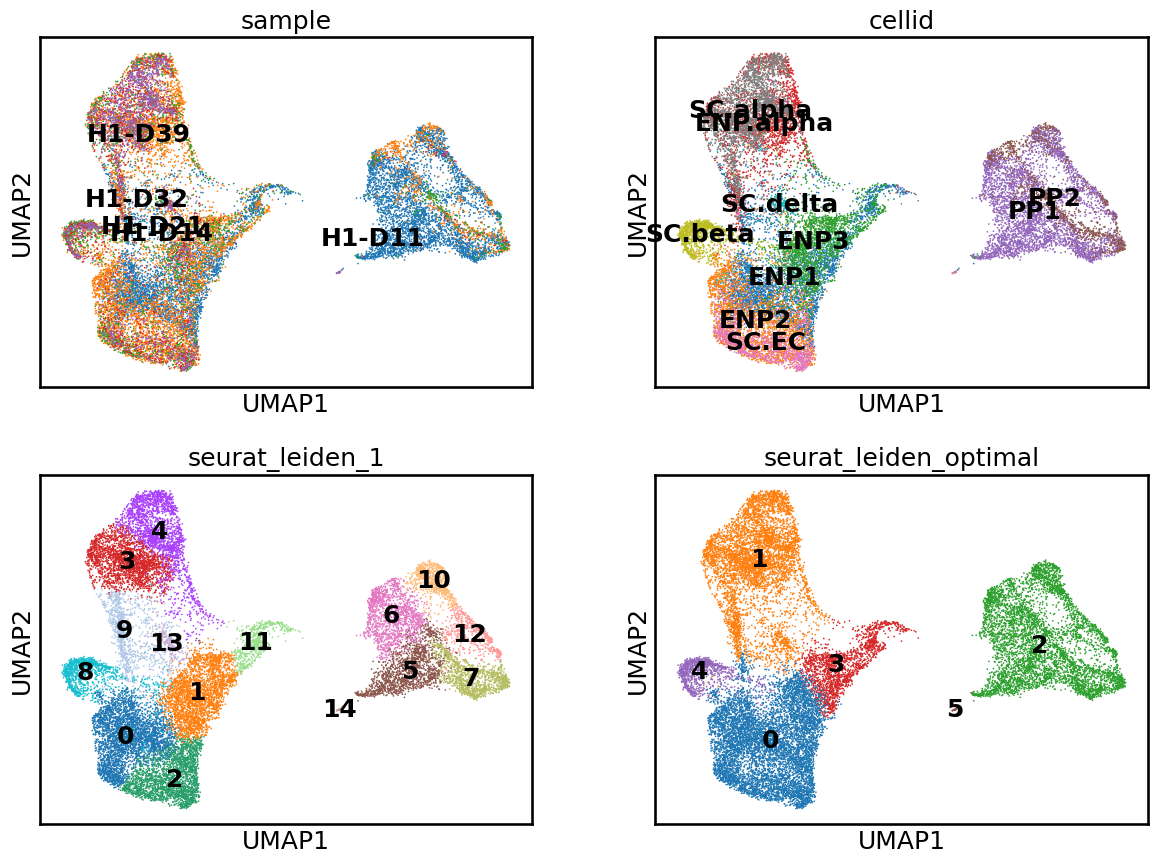

In [63]:
# Plot with sample colors
sc.pl.umap(
    adata_seurat, 
    color=[
        "sample", 
        "cellid", 
        f"seurat_leiden_{leiden_resolution}", 
        "seurat_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Seurat RPCA
TODO

# ComBat

In [119]:
# Make another copy
adata_combat = adata_concat.copy()
adata_combat

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [120]:
# Correct with combat
corrected_X = sc.pp.combat(
    adata_combat,
    key="sample",
    inplace=False,
)

In [123]:
# Add to adata
adata_combat.layers["combat"] = corrected_X
adata_combat.X = corrected_X

In [133]:
# Select highly variable genes for PCA
sc.pp.highly_variable_genes(adata_combat, flavor="cell_ranger", n_top_genes=3000)

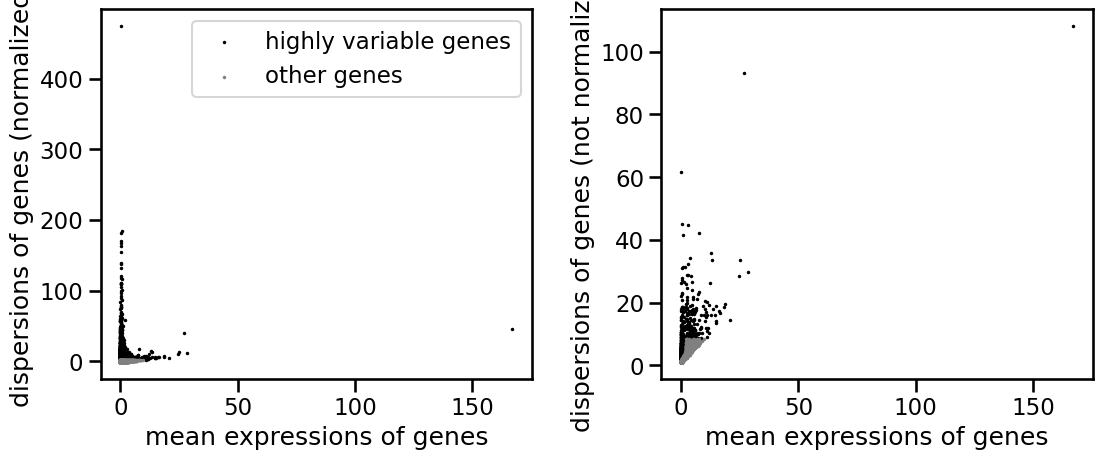

In [141]:
# See what this looks like
sc.pl.highly_variable_genes(adata_combat)

In [134]:
# Run PCA
sc.tl.pca(adata_combat, n_comps=n_comps, svd_solver="arpack", use_highly_variable=True, zero_center=True, dtype="float32", copy=False, random_state=random_state)

In [135]:
# Find neighbors
sc.pp.neighbors(adata_combat, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

In [136]:
# Run UMAP
sc.tl.umap(adata_combat, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="unintegrated")

In [137]:
# Cluster unintegrated data
sc.tl.leiden(adata_combat, key_added=f"combat_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state) #, neighbors_key="unintegrated")

In [138]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_combat,
    label_key="cellid",
    cluster_key="combat_leiden_optimal",
    use_rep="X_pca",
)

Compute neighbors on rep X_pca


resolution: 0.1, nmi: 0.4558258744112025
resolution: 0.2, nmi: 0.47777453067164277
resolution: 0.3, nmi: 0.4281005104491527
resolution: 0.4, nmi: 0.4266290366755063
resolution: 0.5, nmi: 0.38889530423629426
resolution: 0.6, nmi: 0.4205115659829181
resolution: 0.7, nmi: 0.39693826093401874
resolution: 0.8, nmi: 0.39330978153093843
resolution: 0.9, nmi: 0.379677143592268
resolution: 1.0, nmi: 0.38534615845425857
resolution: 1.1, nmi: 0.3978171275498715
resolution: 1.2, nmi: 0.36939284958752283
resolution: 1.3, nmi: 0.3746574774343074
resolution: 1.4, nmi: 0.36895682545005865
resolution: 1.5, nmi: 0.36839243570403657
resolution: 1.6, nmi: 0.3719987600621607
resolution: 1.7, nmi: 0.3607535089826379
resolution: 1.8, nmi: 0.3563382678581673
resolution: 1.9, nmi: 0.35164739590363026
resolution: 2.0, nmi: 0.3636356680013832
optimised clustering against manual_cellid_annotation
optimal cluster resolution: 0.2
optimal score: 0.47777453067164277


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


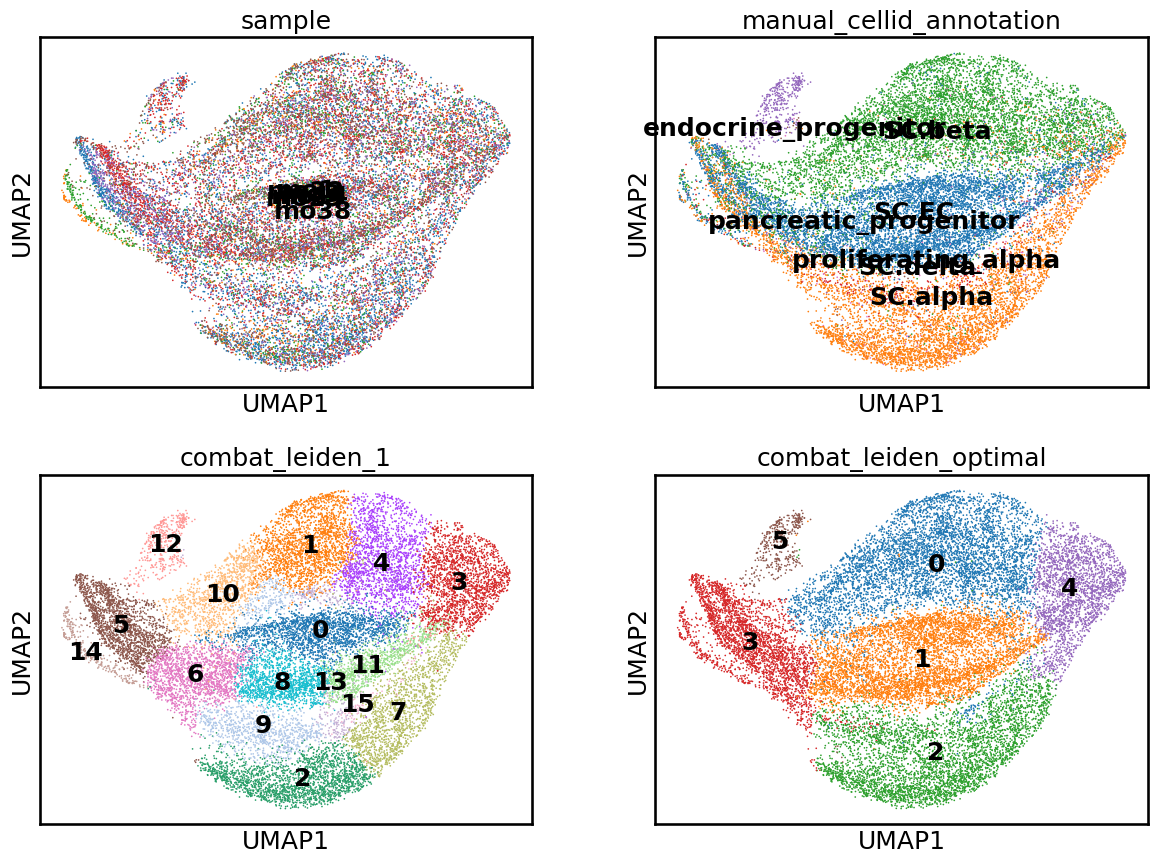

In [140]:
# Plot with sample colors
sc.pl.umap(
    adata_combat, 
    color=[
        "sample", 
        "cellid", 
        f"combat_leiden_{leiden_resolution}", 
        "combat_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Scanorama
TODO

# BBKNN

In [ ]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 100000 else 3

3

In [ ]:
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)

In [ ]:
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
adata_bbknn

AnnData object with n_obs × n_vars = 20552 × 3000
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'at

In [ ]:
sc.tl.umap(adata_bbknn)

In [ ]:
sc.tl.leiden(adata_bbknn, key_added="bbknn_leiden", resolution=leiden_resolution)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


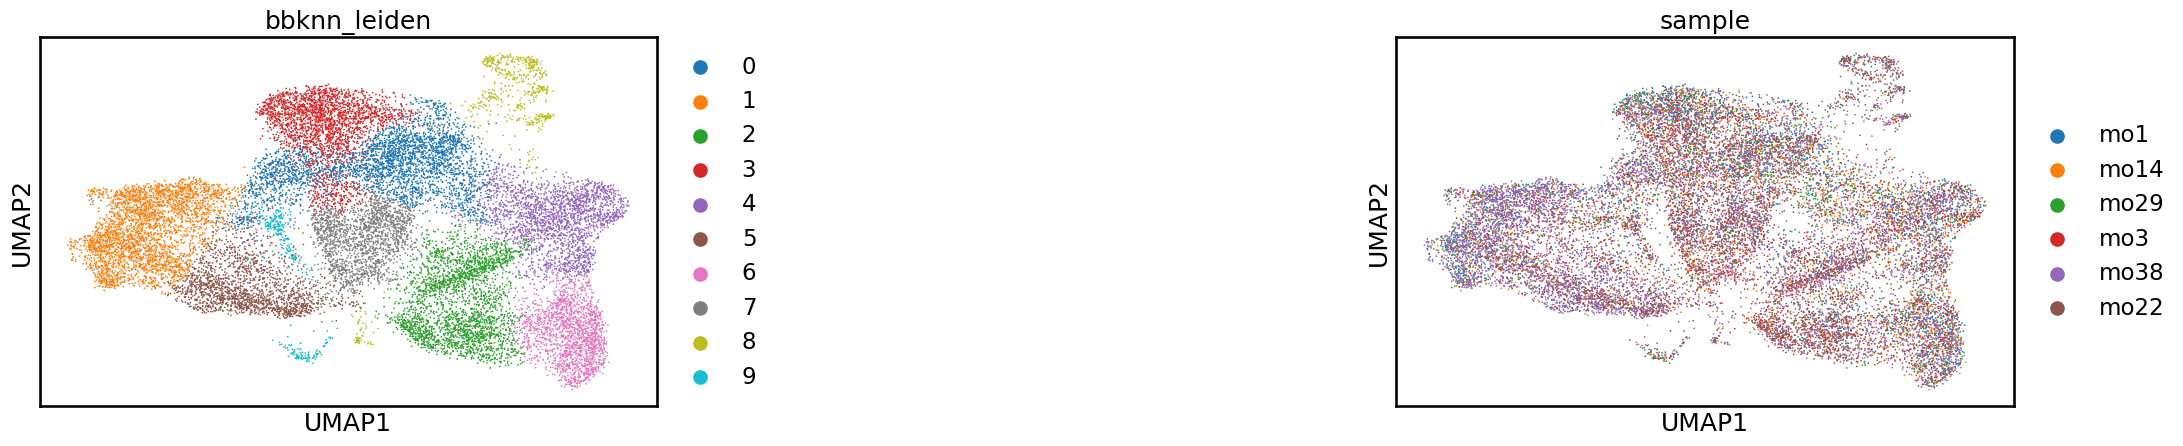

In [ ]:
sc.pl.umap(adata_bbknn, color=["bbknn_leiden", batch_key], wspace=1)

# Metrics

In [84]:
metrics_harmony_py = scib.metrics.metrics_fast(
    adata_sctransform, 
    adata_harmony_py, 
    batch_key="sample", 
    label_key="manual_cellid_annotation", 
    embed="X_pca_harmony",
)

Silhouette score...
PC regression...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [142]:
metrics_harmony_R = scib.metrics.metrics_fast(
    adata_sctransform, 
    adata_harmony_R, 
    batch_key="sample", 
    label_key="manual_cellid_annotation", 
    embed="X_pca_harmony",
)

Silhouette score...
PC regression...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [143]:
metrics_seurat = scib.metrics.metrics_fast(
    adata_sctransform, 
    adata_seurat, 
    batch_key="sample", 
    label_key="manual_cellid_annotation", 
    embed="X_pca",
)

Silhouette score...
PC regression...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [144]:
metrics_combat = scib.metrics.metrics_fast(
    adata_sctransform, 
    adata_combat, 
    batch_key="sample", 
    label_key="manual_cellid_annotation", 
    embed="X_pca",
)

Silhouette score...
PC regression...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [146]:
# Concatenate metrics results
metrics = pd.concat(
    [metrics_harmony_py, metrics_harmony_R, metrics_seurat, metrics_combat],
    axis="columns",
)
# Set methods as column names
metrics = metrics.set_axis(
    ["harmony_py", "harmony_R", "seurat", "combat", "unintegrated"], axis="columns"
)
# Select only the fast metrics
metrics = metrics.loc[
    [
        "ASW_label",
        "ASW_label/batch",
        "PCR_batch",
        "isolated_label_silhouette",
        "graph_conn",
        "hvg_overlap",
    ],
    :,
]
# Transpose so that metrics are columns and methods are rows
metrics = metrics.T
# Remove the HVG overlap metric because it's not relevant to embedding outputs
metrics = metrics.drop(columns=["hvg_overlap"])
metrics

ASW_label  ASW_label/batch  PCR_batch  isolated_label_silhouette  \
harmony_py   0.558886         0.895046   0.693722                   0.475158   
harmony_R    0.558656         0.894153   0.690563                   0.469316   
seurat       0.580533         0.895680   0.000582                   0.538239   
combat       0.499654         0.901760   0.993655                   0.434517   

            graph_conn  
harmony_py    0.872466  
harmony_R     0.888503  
seurat        0.858998  
combat        0.735233

In [147]:
metrics.style.background_gradient(cmap="Blues")

In [148]:
metrics_scaled = (metrics - metrics.min()) / (metrics.max() - metrics.min())
metrics_scaled.style.background_gradient(cmap="Blues")

In [149]:
metrics_scaled["Batch"] = metrics_scaled[
    ["ASW_label/batch", "PCR_batch", "graph_conn"]
].mean(axis=1)
metrics_scaled["Bio"] = metrics_scaled[["ASW_label", "isolated_label_silhouette"]].mean(
    axis=1
)
metrics_scaled.style.background_gradient(cmap="Blues")

# scvi-tools
TODO: The imports currently fail with the scverse-py39-R431 enviroment, but work with the scverse-py38-R431. For now I branched off the scVI run into a separate notebook because scvi-tools requires Python >= 3.9 to run

# DONE!

---

# Scratch

## Packages

In [157]:
import harmony

In [158]:
import scanorama

In [152]:
import trvae

ModuleNotFoundError: No module named 'trvae'

In [160]:
import mnnpy

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float32[:](float32[:, :]), nogil=True)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x155530cc0310>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float32[:, :](float32[:, :], float32[:, :]))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:29: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  dist[i, j] = np.dot(m[i], n[j])
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:88: NumbaDeprecationWarning: The 'nopython' keyword argument was not suppl

In [154]:
import bbknn

In [159]:
import harmonypy

## Cluster proportions

In [ ]:
# Get the cluster proportions across samples
cross_tab = pd.crosstab(adata_concat.obs["sample"], adata_concat.obs["unintegrated_leiden"])
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab_norm

unintegrated_leiden         0         1         2         3         4  \
sample                                                                  
mo1                  0.303021  0.140654  0.082756  0.071429  0.119572   
mo14                 0.236230  0.109343  0.097511  0.088535  0.139943   
mo29                 0.228283  0.198653  0.046465  0.037710  0.115152   
mo3                  0.180663  0.111856  0.178899  0.143613  0.103387   
mo38                 0.142646  0.255089  0.113099  0.089297  0.092745   
mo22                 0.166223  0.085550  0.207668  0.161569  0.088652   

unintegrated_leiden         5         6         7         8         9  
sample                                                                 
mo1                  0.045941  0.131529  0.063877  0.018565  0.022656  
mo14                 0.044472  0.126071  0.115463  0.018360  0.024072  
mo29                 0.037710  0.103704  0.174411  0.035017  0.022896  
mo3                  0.095272  0.076217  0.071277  0.020113  0.018701  
mo38                 0.130499  0.063198  0.071241  0.030696  0.011490  
mo22                 0.109707  0.063608  0.048094  0.054965  0.013963

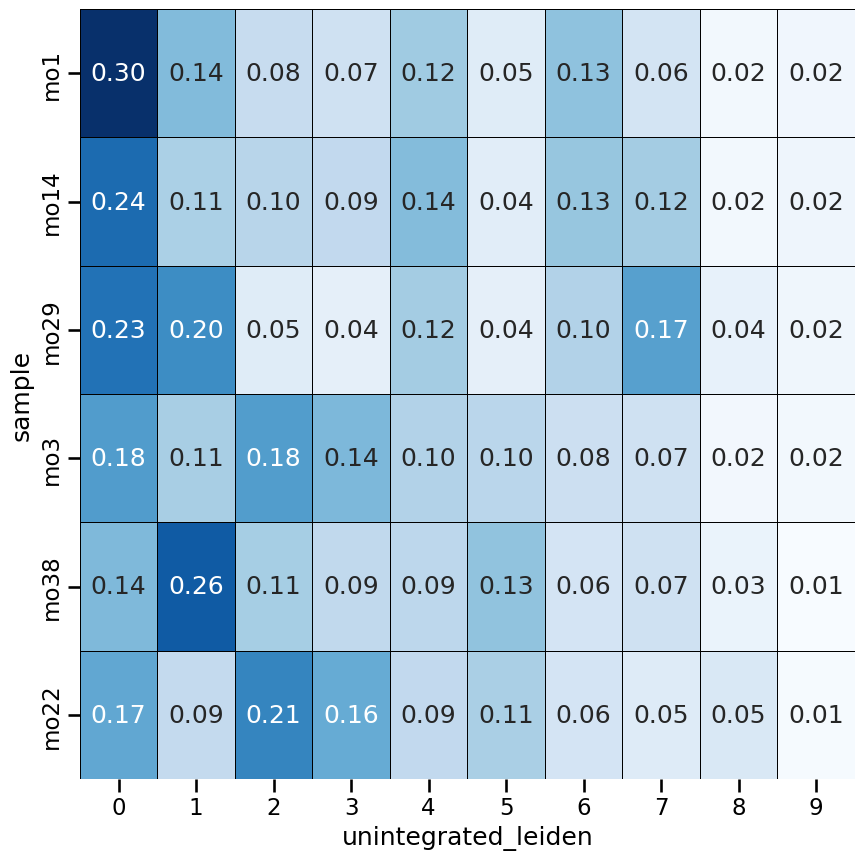

In [ ]:
# Plot heatmap with 2 decimal places and make sure its wide enough
plt.figure(figsize=(10, 10))
sns.heatmap(cross_tab_norm, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, linecolor="black", cbar=False)
plt.show()

## Old Harmony integration code

In [ ]:
%%R
# Need PCA
sobj = RunPCA(sobj, verbose = FALSE)

In [ ]:
%%R
# Run Harmony
sobj <- RunHarmony(
    object = sobj,
    group.by.vars = c('sample'),
    assay.use = 'SCT',
    max.iter.harmony=25,
    project.dim = FALSE
)

R[write to console]: Transposing data matrix

R[write to console]: Initializing state using k-means centroids initialization

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

In [ ]:
%%R -o harmony_embedding -o umap_harmony_embedding -o harmony_clusters
# With Harmony
sobj = FindNeighbors(sobj, reduction = "harmony", dims = 1:30, graph.name=c("harmony_knn", 'harmony_snn'))
sobj = FindClusters(sobj, resolution = 1, graph.name = 'harmony_snn', algorithm = 4, verbose = TRUE)
sobj = RunUMAP(sobj, reduction = "harmony", dims = 1:30, reduction.name='umap.harmony', reduction.key='harmonyUMAP_', verbose = FALSE)
harmony_embedding = Embeddings(sobj, reduction = "harmony")
umap_harmony_embedding = Embeddings(sobj, reduction = "umap.harmony")
harmony_clusters = sobj$seurat_clusters
sobj$harmony_clusters = harmony_clusters

R[write to console]: Computing nearest neighbor graph

R[write to console]: Computing SNN



In [ ]:
# Add in the harmony embeddings
adata_concat.obsm["X_sctransform_pca_harmony"] = harmony_embedding
adata_concat.obsm["X_sctransform_pca_harmony_umap"] = umap_harmony_embedding
adata_concat.obs["harmony_sctransform_leiden_1"] = harmony_clusters

In [ ]:
# Get the UMAP ready to plot
adata_concat.obsm["X_umap"] = adata_concat.obsm["X_sctransform_pca_harmony_umap"]

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


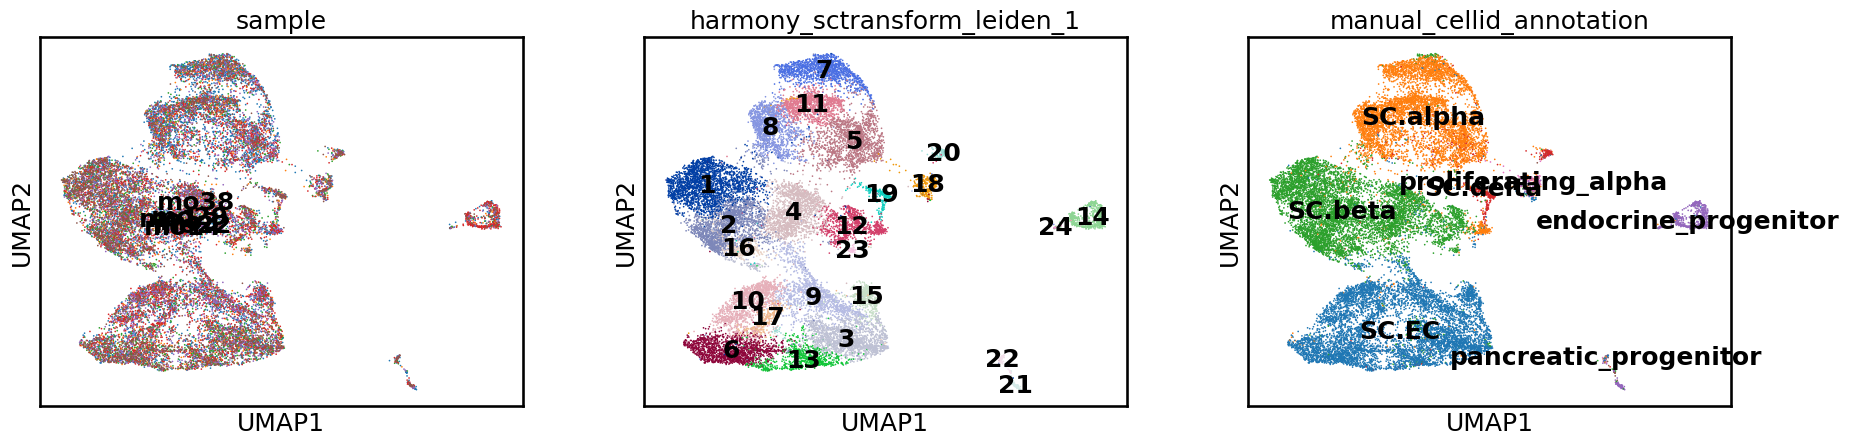

In [ ]:
# Plot with sample colors
sc.pl.umap(adata_concat, color=["sample", "harmony_sctransform_leiden_1", "manual_cellid_annotation"], legend_loc="on data")